# $4\pi$ beam convolution

TOAST provides an interface, `OpSimConviqt`, to the spherical harmonic convolution library, `libconviqt`.  It was developed by Gary Prezeau and Martin Reinecke and described in
```
G. Prézeau and M. Reinecke:
Algorithm for the Evaluation of Reduced Wigner Matrices,
APJS 190 (2010) 267
```
[arXiv:1002.1050](https://arxiv.org/abs/1002.1050).  This particular implementation of the algorithm is available at https://github.com/hpc4cmb/libconviqt.

In [1]:
# Are you using a special reservation for a workshop?
# If so, set it here:
nersc_reservation = None # "toast3"

# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    check_nersc,
    fake_focalplane
)
nersc_host, nersc_repo, nersc_resv = check_nersc(reservation=nersc_reservation)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer

Not running at NERSC, slurm jobs disabled.


## Method

`libconviqt` takes in spherical harmonic expansions of the beam and the sky and then synthesizes TOD samples at sample positions in the proper orientation. For efficiency, the sky is distributed as isolatitude rings and then each process gets the detector samples that fall on their rings. The calculation itself has two steps, first `conviqt` builds a 3D interpolator of the beam-convolved sky on a grid of $(\theta, \phi, \psi)$ and then the detector samples are interpolated from the grid.  Finally the samples are communited back to the processes that own them.

Typically the interpolation step dominates but if there are few detector samples and the sky and beam expansion orders are high, it is possible that building the interpolator is more expensive.

## Example Inputs

First we will generate the inputs needed for the simulation, in particular the sky and beams.

### Create a high resolution point source map to convolve with the beam

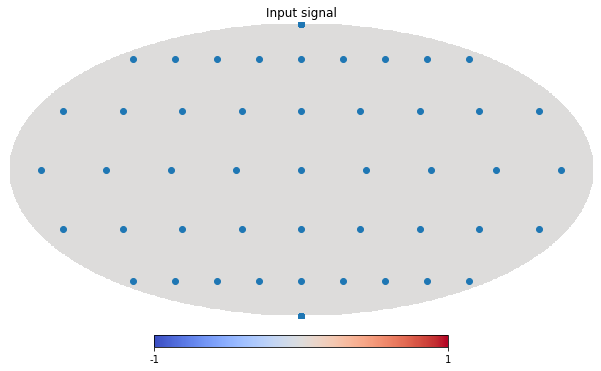

In [2]:
import healpy as hp
import numpy as np

nside_high = 1024
npix_high = 12 * nside_high ** 2

pointsource_map = np.zeros([3, npix_high])
coords = []

for lon in np.linspace(0, 360, 9, endpoint=False):
    for lat in np.linspace(-90, 90, 7):
        pix = hp.ang2pix(nside_high, lon, lat, lonlat=True)
        # Add a completely unpolarized source and see if beam asymmetries manufacture polarization
        pointsource_map[0, pix] = 1
        coords.append((lon, lat))

coords = np.vstack(coords).T

hp.mollview(np.zeros(12), title="Input signal", cmap="coolwarm")
hp.projplot(np.pi/2 - np.radians(coords[1]), np.radians(coords[0]), 'o')

lmax_high = nside_high * 2

cl, alm = hp.anafast(pointsource_map, lmax=lmax_high, iter=0, alm=True)
hp.write_map("sim_sources_map.fits", hp.reorder(pointsource_map, r2n=True), nest=True, overwrite=True)
hp.write_alm("slm.fits", alm, overwrite=True)

### Create asymmetric beam

In [3]:
beam_map = np.zeros([3, npix_high])
x, y, z = hp.pix2vec(nside_high, np.arange(npix_high))

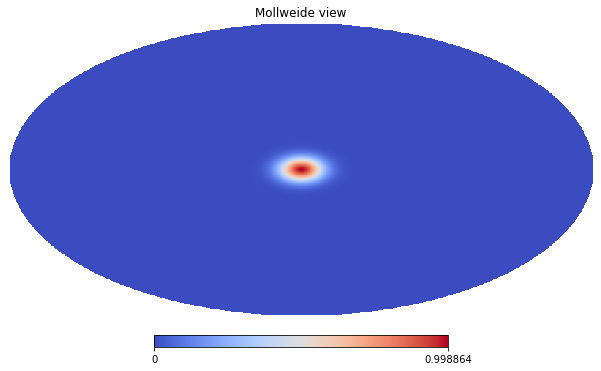

In [4]:
xvar = .01
yvar = 5 * xvar
beam = np.exp(-(x ** 2 / xvar + y ** 2 / yvar))
beam[z < 0] = 0
hp.mollview(beam, cmap="coolwarm", rot=[0, 90])
beam_map = np.zeros([3, npix_high])
beam_map[0] = beam
beam_map[1] = beam
bl, blm = hp.anafast(beam_map, lmax=lmax_high, iter=0, alm=True)
hp.write_alm("blm.fits", blm, overwrite=True)

## Example Pipeline

Since libconviqt requires MPI (which is not available if this notebook is running on a NERSC login node), we instead write a script to a file and run it.  If you have a notebook running on a laptop or workstation with MPI, then you can do these steps directly in the notebook cells rather than writing it to a file.

In [9]:
%%writefile toast_conviqt_sim.py

import toast
from toast.mpi import MPI

import argparse

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    fake_focalplane
)

from toast.todmap import (
    slew_precession_axis,
    TODSatellite,
    OpPointingHpix,
    OpSimConviqt,
    OpMapMaker
)

import toast.pipeline_tools

env = toast.Environment.get()

# We have many small observations, so we should use a small
# group size.  Here we choose a group size of one process.

comm = toast.Comm(world=MPI.COMM_WORLD, groupsize=1)
if comm.world_rank == 0:
    print(env)

# Create our fake focalplane

fp = fake_focalplane()

detnames = list(sorted(fp.keys()))
detquat = {x: fp[x]["quat"] for x in detnames}

# Scan parameters

alpha = 50.0      # precession opening angle, degrees
beta = 45.0       # spin opening angle, degrees
p_alpha = 25.0    # precession period, minutes
p_beta = 1.25     # spin period, minutes
samplerate = 8.9  # sample rate, Hz
hwprpm = 5.0      # HWP rotation in RPM
nside = 64        # Healpix NSIDE

# Input beam and sky

sky_file = "slm.fits"
beam_file = "blm.fits"

# We will use one observation per day, with no gaps in between, and
# run for 30 days.

obs_samples = int(24 * 3600.0 * samplerate) - 1
nobs = 4  # Need 30 for a full sky

# Slew the precession axis so that it completes one circle

deg_per_day = 360.0 / nobs

# Create distributed data

data = toast.Data(comm)

# Append observations

for ob in range(nobs):
    # Am I in the group that has this observation?
    if (ob % comm.ngroups) != comm.group:
        # nope...
        continue
    obsname = "{:03d}".format(ob)
    obsfirst = ob * (obs_samples + 1)
    obsstart = 24 * 3600.0
    tod = TODSatellite(
        comm.comm_group, 
        detquat, 
        obs_samples, 
        firstsamp=obsfirst,
        firsttime=obsstart,
        rate=samplerate,
        spinperiod=p_beta,
        spinangle=beta,
        precperiod=p_alpha,
        precangle=alpha,
        coord="E",
        hwprpm=hwprpm
    )
    qprec = np.empty(4 * tod.local_samples[1], dtype=np.float64).reshape((-1, 4))
    slew_precession_axis(
        qprec,
        firstsamp=obsfirst,
        samplerate=samplerate,
        degday=deg_per_day,
    )
    tod.set_prec_axis(qprec=qprec)
    obs = dict()
    obs["tod"] = tod
    # Conviqt requires at least minimal focal plane information to be present in the observation
    obs["focalplane"] = toast.pipeline_tools.Focalplane(fp)
    data.obs.append(obs)

# Make a simple pointing matrix

pointing = OpPointingHpix(nside=nside, nest=True, mode="IQU")
pointing.exec(data)

# Create and apply the conviqt operator

conviqt = OpSimConviqt(
    comm.comm_rank,
    sky_file,
    beam_file,
    lmax=512,  # Will use maximum from file
    beammmax=16,  # Will use maximum from file
    pol=True,
    fwhm=0,
    order=7,  # Recommend using 13 or atleast 11
    calibrate=True,
    dxx=True,
    out="signal",
    quat_name=None,
    flag_name=None,
    flag_mask=255,
    common_flag_name=None,
    common_flag_mask=255,
    apply_flags=False,
    remove_monopole=False,
    remove_dipole=False,
    normalize_beam=True,
    verbosity=1,
)
conviqt.exec(data)

# Set up the map maker and run.

mapmaker = OpMapMaker(
    nside=nside,
    nnz=3,
    name="signal",  # same as used to generate the timestreams above
    outdir="maps",
    outprefix="toast_test_",
    baseline_length=10,
    # maskfile=self.maskfile_binary,
    # weightmapfile=self.maskfile_smooth,
    # subharmonic_order=None,
    iter_max=100,
    use_noise_prior=False,
    # precond_width=30,
)
mapmaker.exec(data)

Overwriting toast_conviqt_sim.py


Now run the script interactively on a compute node:

In [6]:
import subprocess as sp

command = "python toast_conviqt_sim.py"
runstr = None

if nersc_host is not None:
    runstr = "export OMP_NUM_THREADS=4; srun -N 2 -C haswell -n 32 -c 4 --cpu_bind=cores -t 00:10:00"
    if nersc_resv is not None:
        runstr = "{} --reservation {}".format(runstr, nersc_resv)
else:
    # Just use mpirun
    runstr = "mpirun -np 4"

runcom = "{} {}".format(runstr, command)
print(runcom, flush=True)
sp.check_call(runcom, stderr=sp.STDOUT, shell=True)

mpirun -np 4 python toast_conviqt_sim.py
Traceback (most recent call last):
  File "toast_conviqt_sim.py", line 141, in <module>
    conviqt.exec(data)
  File "/Users/reijo/Software/macports/lib/python3.7/site-packages/toast/timing.py", line 43, in df
    return f(*args, **kwargs)
  File "/Users/reijo/Software/macports/lib/python3.7/site-packages/toast/todmap/conviqt.py", line 129, in exec
    raise RuntimeError("libconviqt is not available")
RuntimeError: libconviqt is not available
Traceback (most recent call last):
  File "toast_conviqt_sim.py", line 141, in <module>
    conviqt.exec(data)
  File "/Users/reijo/Software/macports/lib/python3.7/site-packages/toast/timing.py", line 43, in df
    return f(*args, **kwargs)
  File "/Users/reijo/Software/macports/lib/python3.7/site-packages/toast/todmap/conviqt.py", line 129, in exec
    raise RuntimeError("libconviqt is not available")
RuntimeError: libconviqt is not available
<toast.Environment
  Source code version = 2.3.5.dev1483
  Logg

CalledProcessError: Command 'mpirun -np 4 python toast_conviqt_sim.py' returned non-zero exit status 1.

Now plot some of the outputs:

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


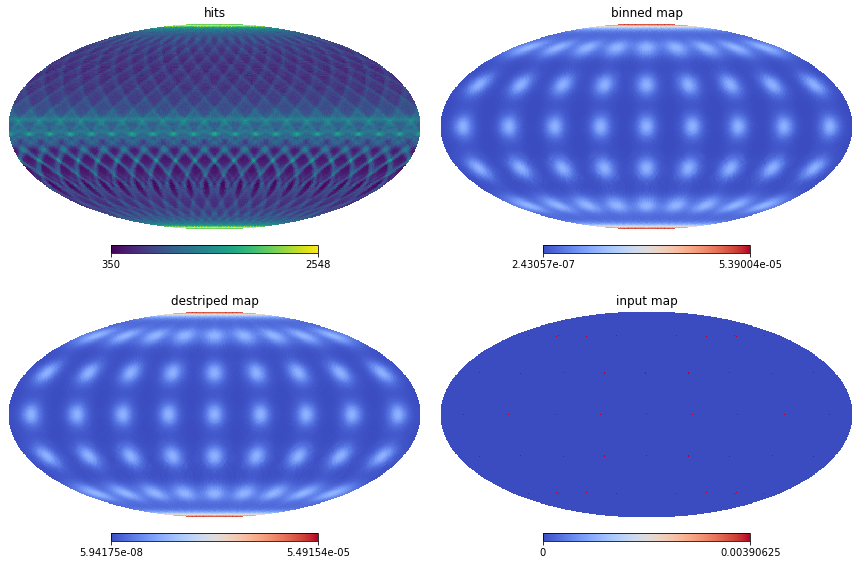

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=[12, 8])

hitmap = hp.read_map("maps/toast_test_hits.fits")
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, sub=[2, 2, 1], title="hits")

binmap = hp.read_map("maps/toast_test_binned.fits")
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[2, 2, 2], title="binned map", cmap="coolwarm")

destriped = hp.read_map("maps/toast_test_destriped.fits")
destriped[destriped == 0] = hp.UNSEEN
hp.mollview(destriped, sub=[2, 2, 3], title="destriped map", cmap="coolwarm")

inmap = hp.ud_grade(hp.read_map("sim_sources_map.fits"), hp.get_nside(destriped))
inmap[hitmap == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[2, 2, 4], title="input map", cmap="coolwarm")


## Exercises

- Plot the polarization of the simulated signal above
- Modify the scan strategy so that the beam elongation is more visible